In [1]:
from functions import *
from bayes_opt import BayesianOptimization

In [2]:
n=6
T=0.1
t_max=10
interpolator_kind='cubic'

In [3]:
def loss_ra(x1,x2,x3):
    '''
    Computes the negative average delta for multiple random Ising models 
    using for a given ramp-up schedule and maximum time.
    '''
    n_random_models = 1

    ramp_up_schedule = [x1,x2,x3]

    schedule = get_symmetric_schedule(ramp_up_schedule) # mirror and append the ramp up schedule
    schedule_interpolator = get_schedule_interpolator(schedule, kind=interpolator_kind) # get an interpolating function for the continuos schedule
    
    delta_sum = 0    
    for seed in range(n_random_models):
        m = RandomIsingModel(n=n, seed=seed)
        proposal_mat_ra = get_proposal_mat_ra(m, schedule_interpolator, t_max, assert_symmetry=False)
        P = get_transition_matrix(m, T, proposal_mat_ra)
        delta_sum += get_delta(P)
    
    delta_avg = delta_sum / n_random_models
    return delta_avg

In [4]:
pbounds = {'x1': (0,4), 'x2': (0,4), 'x3': (0,4)}

optimizer = BayesianOptimization(
    f=loss_ra,
    pbounds=pbounds,
    random_state=1,
)

In [5]:
optimizer.maximize(
    init_points=10,
    n_iter=1000,
)

|   iter    |  target   |    x1     |    x2     |    x3     |
-------------------------------------------------------------


| 1         | 0.002285  | 1.668     | 2.881     | 0.0004575 |
| 2         | 0.02558   | 1.209     | 0.587     | 0.3694    |


| 3         | 0.02302   | 0.745     | 1.382     | 1.587     |


| 4         | 0.08872   | 2.155     | 1.677     | 2.741     |


| 5         | 0.003718  | 0.8178    | 3.512     | 0.1096    |


| 6         | 0.09326   | 2.682     | 1.669     | 2.235     |


| 7         | 0.02238   | 0.5615    | 0.7924    | 3.203     |


| 8         | 0.02106   | 3.873     | 1.254     | 2.769     |


| 9         | 0.02429   | 3.506     | 3.578     | 0.3402    |


| 10        | 0.0073    | 0.1562    | 0.6793    | 3.513     |


| 11        | 0.05083   | 2.493     | 2.552     | 2.464     |


| 12        | 0.03496   | 2.309     | 0.9757    | 2.255     |


| 13        | 0.09295   | 2.708     | 1.761     | 2.773     |


| 14        | 0.01814   | 2.28      | 1.811     | 3.529     |


| 15        | 0.0577    | 2.29      | 1.888     | 2.339     |


| 16        | 0.05892   | 2.6       | 1.449     | 2.617     |


| 17        | 0.06674   | 3.822     | 2.656     | 1.883     |


| 18        | 0.02444   | 1.955     | 3.365     | 3.916     |


| 19        | 0.009123  | 2.871     | 1.9       | 2.45      |


| 20        | 0.0491    | 3.42      | 2.877     | 3.648     |


| 21        | 0.03889   | 2.708     | 2.192     | 1.533     |


| 22        | 0.01374   | 0.563     | 0.5575    | 1.267     |


| 23        | 0.03674   | 1.096     | 3.057     | 0.2675    |


| 24        | 0.01424   | 3.757     | 3.8       | 1.117     |


| 25        | 0.02776   | 2.393     | 0.4508    | 0.4671    |


| 26        | 0.08704   | 2.454     | 2.23      | 2.614     |


| 27        | 0.01313   | 0.06725   | 1.033     | 3.202     |


| 28        | 0.05658   | 2.682     | 1.801     | 2.744     |


| 29        | 0.07284   | 2.707     | 1.699     | 2.225     |


| 30        | 0.06571   | 2.617     | 1.665     | 2.181     |


| 31        | 0.06653   | 2.512     | 2.286     | 2.604     |


| 32        | 0.02009   | 0.9202    | 0.2591    | 2.815     |


| 33        | 0.02312   | 2.161     | 1.752     | 2.695     |


| 34        | 0.01472   | 2.394     | 0.4605    | 1.637     |


| 35        | 0.01293   | 3.357     | 1.674     | 1.184     |


| 36        | 0.0739    | 2.162     | 1.663     | 2.828     |


| 37        | 0.0748    | 2.738     | 1.706     | 2.845     |


| 38        | 0.003983  | 0.172     | 1.659     | 0.02117   |


| 39        | 0.03485   | 2.088     | 1.573     | 2.734     |


| 40        | 0.08104   | 2.735     | 1.731     | 2.806     |


| 41        | 0.08871   | 2.164     | 1.649     | 2.77      |


| 42        | 0.01814   | 0.4128    | 0.2286    | 1.479     |


| 43        | 0.007803  | 1.748     | 0.7739    | 0.3031    |


| 44        | 0.09991   | 2.512     | 2.204     | 2.546     |


| 45        | 0.09397   | 2.67      | 1.628     | 2.302     |


| 46        | 0.02366   | 2.7       | 1.588     | 2.237     |


| 47        | 0.09404   | 2.633     | 1.657     | 2.339     |


| 48        | 0.07566   | 2.5       | 2.259     | 2.481     |


| 49        | 0.1044    | 2.545     | 1.668     | 2.319     |


| 50        | 0.02122   | 1.019     | 3.382     | 0.5226    |


| 51        | 0.02898   | 3.019     | 0.9455    | 3.501     |


| 52        | 0.02834   | 2.546     | 2.092     | 2.573     |


| 53        | 0.0806    | 3.243     | 2.989     | 3.558     |


| 54        | 0.07856   | 2.147     | 1.67      | 2.795     |


| 55        | 0.07077   | 2.658     | 1.7       | 2.781     |


| 56        | 0.08995   | 2.139     | 1.628     | 2.756     |


| 57        | 0.09383   | 2.672     | 1.637     | 2.372     |


| 58        | 0.1044    | 2.603     | 1.653     | 2.317     |


| 59        | 0.06201   | 2.729     | 1.769     | 2.808     |


| 60        | 0.05328   | 2.717     | 1.684     | 2.692     |


| 61        | 0.02671   | 2.475     | 1.639     | 2.314     |


| 62        | 0.0483    | 0.1688    | 2.631     | 3.965     |


| 63        | 0.06428   | 3.292     | 2.978     | 3.49      |


| 64        | 0.007764  | 0.4346    | 3.262     | 3.899     |


| 65        | 0.005093  | 3.487     | 0.7144    | 1.675     |


| 66        | 0.009345  | 0.2876    | 0.6244    | 2.71      |


| 67        | 0.05521   | 2.774     | 1.639     | 2.796     |


| 68        | 0.1065    | 3.254     | 2.998     | 3.57      |


| 69        | 0.0194    | 2.461     | 2.159     | 2.499     |


| 70        | 0.00896   | 1.029     | 2.966     | 2.644     |


| 71        | 0.07582   | 2.713     | 1.721     | 2.81      |


| 72        | 0.01751   | 0.345     | 2.189     | 0.5801    |


| 73        | 0.06548   | 3.281     | 2.949     | 3.637     |


| 74        | 0.07905   | 3.386     | 3.059     | 3.56      |


| 75        | 0.08509   | 2.567     | 1.628     | 2.382     |


| 76        | 0.03984   | 2.603     | 1.584     | 2.337     |


| 77        | 0.07319   | 2.527     | 1.721     | 2.362     |


| 78        | 0.09074   | 3.303     | 3.131     | 3.592     |


| 79        | 0.04993   | 2.713     | 1.791     | 2.78      |


| 80        | 0.07668   | 3.177     | 3.054     | 3.609     |


| 81        | 0.03834   | 1.833     | 3.877     | 2.276     |


| 82        | 0.04929   | 2.59      | 2.258     | 2.543     |


| 83        | 0.01237   | 0.5379    | 3.755     | 0.03788   |


| 84        | 0.07145   | 2.19      | 1.624     | 2.706     |


| 85        | 0.07099   | 0.7071    | 0.8369    | 2.122     |


| 86        | 0.01237   | 3.302     | 0.4796    | 2.233     |


| 87        | 0.08251   | 3.273     | 3.02      | 3.581     |


| 88        | 0.07397   | 2.046     | 2.843     | 3.732     |


| 89        | 0.08706   | 3.384     | 3.118     | 3.59      |


| 90        | 0.09448   | 3.324     | 3.361     | 2.15      |


| 91        | 0.0819    | 2.481     | 2.241     | 2.556     |


| 92        | 0.01954   | 3.17      | 0.5636    | 3.169     |


| 93        | 0.04383   | 3.354     | 3.151     | 3.613     |


| 94        | 0.007041  | 1.56      | 0.1412    | 0.6194    |


| 95        | 0.001333  | 0.1017    | 0.1445    | 0.1193    |


| 96        | 0.05701   | 3.347     | 3.079     | 3.616     |


| 97        | 0.07081   | 2.646     | 1.714     | 2.33      |


| 98        | 0.07744   | 3.281     | 2.973     | 3.579     |


| 99        | 0.1045    | 2.518     | 2.203     | 2.628     |


| 100       | 0.0638    | 3.338     | 3.115     | 3.54      |


| 101       | 0.08247   | 2.748     | 1.742     | 2.724     |


| 102       | 0.04739   | 2.504     | 2.246     | 2.658     |


| 103       | 0.02077   | 2.556     | 0.3966    | 0.574     |


| 104       | 0.06756   | 2.626     | 1.661     | 2.439     |


| 105       | 0.07122   | 2.622     | 1.644     | 2.261     |


| 106       | 0.02688   | 1.594     | 2.624     | 1.137     |


| 107       | 0.05679   | 3.245     | 3.12      | 3.588     |


| 108       | 0.08198   | 3.214     | 3.037     | 3.679     |


| 109       | 0.09154   | 2.519     | 2.178     | 2.624     |


| 110       | 0.01539   | 1.18      | 0.03402   | 0.623     |


| 111       | 0.06714   | 3.601     | 3.26      | 2.676     |


| 112       | 0.0892    | 2.183     | 1.652     | 2.787     |


| 113       | 0.1001    | 3.398     | 3.352     | 2.172     |


| 114       | 0.09988   | 3.461     | 3.343     | 2.12      |


| 115       | 0.06874   | 2.754     | 2.324     | 1.627     |


| 116       | 0.1116    | 3.385     | 3.454     | 2.19      |


| 117       | 0.07317   | 3.464     | 3.371     | 2.19      |


| 118       | 0.05336   | 3.417     | 3.418     | 2.099     |


| 119       | 0.02639   | 2.581     | 0.8183    | 2.634     |


| 120       | 0.1008    | 3.422     | 3.37      | 2.129     |


| 121       | 0.01      | 0.7045    | 0.7826    | 0.5532    |


| 122       | 0.01491   | 3.617     | 0.2148    | 0.5355    |


| 123       | 0.06443   | 3.484     | 3.274     | 2.091     |


| 124       | 0.05446   | 3.42      | 3.521     | 2.169     |


| 125       | 0.03421   | 3.318     | 3.28      | 2.132     |


| 126       | 0.1124    | 3.291     | 3.484     | 2.172     |


| 127       | 0.05839   | 2.268     | 1.203     | 1.768     |


| 128       | 0.05194   | 3.272     | 3.569     | 2.156     |


| 129       | 0.05812   | 3.296     | 3.443     | 2.196     |


| 130       | 0.08615   | 2.518     | 1.725     | 2.248     |


| 131       | 0.1224    | 3.368     | 3.479     | 2.21      |


| 132       | 0.1176    | 3.418     | 3.478     | 2.205     |


| 133       | 0.1061    | 3.335     | 3.521     | 2.156     |


| 134       | 0.01606   | 0.1619    | 2.131     | 1.756     |


| 135       | 0.08644   | 2.686     | 1.626     | 2.282     |


| 136       | 0.1204    | 3.426     | 3.441     | 2.232     |


| 137       | 0.0546    | 3.115     | 2.218     | 3.393     |


| 138       | 0.09545   | 3.294     | 3.489     | 2.095     |


| 139       | 0.08034   | 2.572     | 1.682     | 2.37      |


| 140       | 0.06912   | 3.302     | 3.53      | 2.201     |


| 141       | 0.04231   | 1.627     | 2.936     | 0.4179    |


| 142       | 0.1255    | 3.431     | 3.452     | 2.213     |


| 143       | 0.09562   | 3.314     | 3.413     | 2.061     |


| 144       | 0.05298   | 2.679     | 2.68      | 1.956     |


| 145       | 0.04752   | 1.638     | 3.39      | 2.137     |


| 146       | 0.006086  | 0.3352    | 3.673     | 0.2831    |


| 147       | 0.00408   | 2.116     | 0.566     | 3.717     |


| 148       | 0.04856   | 3.429     | 3.521     | 2.257     |


| 149       | 0.04007   | 2.334     | 2.153     | 0.8433    |


| 150       | 0.06262   | 2.57      | 2.218     | 2.63      |


| 151       | 0.09528   | 3.437     | 3.311     | 2.065     |


| 152       | 0.09291   | 3.207     | 3.013     | 3.616     |


| 153       | 0.006177  | 0.2098    | 3.151     | 1.353     |


| 154       | 0.04749   | 3.286     | 3.472     | 1.994     |


| 155       | 0.04339   | 2.304     | 3.328     | 3.397     |


| 156       | 0.08954   | 2.76      | 1.578     | 2.365     |


| 157       | 0.04733   | 3.757     | 0.7062    | 0.9495    |


| 158       | 0.06424   | 1.833     | 3.284     | 1.195     |


| 159       | 0.07218   | 2.634     | 1.715     | 2.334     |


| 160       | 0.06724   | 3.29      | 3.465     | 2.139     |


| 161       | 0.05575   | 2.249     | 1.694     | 2.745     |


| 162       | 0.1024    | 3.386     | 3.417     | 2.332     |


| 163       | 0.1181    | 3.378     | 3.449     | 2.246     |


| 164       | 0.1171    | 3.452     | 3.402     | 2.366     |


| 165       | 0.08033   | 2.579     | 1.708     | 2.276     |


| 166       | 0.08382   | 2.813     | 1.601     | 2.378     |


| 167       | 0.01957   | 0.5406    | 1.224     | 3.701     |


| 168       | 0.07581   | 2.732     | 1.648     | 2.338     |


| 169       | 0.1034    | 3.414     | 3.415     | 2.309     |


| 170       | 0.01431   | 2.795     | 1.228     | 0.5228    |


| 171       | 0.04351   | 1.997     | 0.871     | 1.015     |


| 172       | 0.1132    | 3.45      | 3.412     | 2.31      |


| 173       | 0.03305   | 1.027     | 2.768     | 2.942     |


| 174       | 0.02211   | 0.9372    | 0.9373    | 2.573     |


| 175       | 0.03958   | 3.523     | 3.121     | 3.584     |


| 176       | 0.04059   | 2.371     | 3.308     | 1.333     |


| 177       | 0.05608   | 3.365     | 3.401     | 2.271     |


| 178       | 0.111     | 3.399     | 3.454     | 2.339     |


| 179       | 0.1271    | 3.498     | 3.384     | 2.454     |


| 180       | 0.1162    | 3.371     | 3.448     | 2.254     |


| 181       | 0.01124   | 3.394     | 0.5905    | 1.9       |


| 182       | 0.08757   | 3.475     | 3.42      | 2.426     |


| 183       | 0.0832    | 3.568     | 3.396     | 2.437     |


| 184       | 0.06541   | 3.556     | 3.297     | 2.478     |


| 185       | 0.1201    | 3.485     | 3.431     | 2.202     |


| 186       | 0.03271   | 1.335     | 1.088     | 1.94      |


| 187       | 0.113     | 3.331     | 3.485     | 2.283     |


| 188       | 0.04386   | 3.701     | 2.967     | 2.149     |


| 189       | 0.02659   | 3.454     | 3.476     | 2.496     |


| 190       | 0.06724   | 3.497     | 3.46      | 2.291     |


| 191       | 0.05906   | 3.447     | 3.353     | 2.38      |


| 192       | 0.01126   | 0.05554   | 2.984     | 0.3474    |


| 193       | 0.1274    | 3.51      | 3.372     | 2.494     |


| 194       | 0.1018    | 3.402     | 3.323     | 2.126     |


| 195       | 0.03713   | 1.356     | 1.263     | 1.453     |


| 196       | 0.1249    | 3.41      | 3.42      | 2.399     |


| 197       | 0.127     | 3.513     | 3.426     | 2.236     |


| 198       | 0.09283   | 3.499     | 3.339     | 2.523     |


| 199       | 0.1274    | 3.545     | 3.436     | 2.201     |


| 200       | 0.01064   | 1.313     | 1.672     | 0.2846    |


| 201       | 0.02641   | 0.5127    | 0.1439    | 1.326     |


| 202       | 0.04743   | 3.333     | 3.48      | 2.416     |


| 203       | 0.09661   | 3.554     | 3.393     | 2.224     |


| 204       | 0.07333   | 2.754     | 3.878     | 3.665     |


| 205       | 0.06094   | 3.865     | 2.242     | 0.9218    |


| 206       | 0.06647   | 2.831     | 1.523     | 2.41      |


| 207       | 0.06942   | 3.491     | 3.337     | 2.475     |


| 208       | 0.06769   | 3.515     | 3.374     | 2.278     |


| 209       | 0.05502   | 3.901     | 1.887     | 2.797     |


| 210       | 0.04614   | 3.549     | 3.416     | 2.576     |


| 211       | 0.04928   | 3.53      | 3.404     | 2.51      |


| 212       | 0.02033   | 1.249     | 3.213     | 0.6086    |


| 213       | 0.08166   | 3.379     | 3.386     | 2.429     |


| 214       | 0.09934   | 3.499     | 3.412     | 2.212     |


| 215       | 0.04941   | 3.477     | 3.46      | 2.366     |


| 216       | 0.06095   | 3.55      | 3.48      | 2.183     |


| 217       | 0.06008   | 3.416     | 3.41      | 2.205     |


| 218       | 0.1174    | 2.491     | 2.205     | 2.589     |


| 219       | 0.06592   | 3.567     | 3.38      | 2.18      |


| 220       | 0.1098    | 3.501     | 3.429     | 2.158     |


| 221       | 0.01493   | 1.0       | 0.9378    | 3.262     |


| 222       | 0.09415   | 3.328     | 3.368     | 1.98      |


| 223       | 0.1102    | 2.739     | 1.566     | 2.454     |


| 224       | 0.08008   | 3.342     | 3.328     | 2.043     |


| 225       | 0.06375   | 3.542     | 3.3       | 2.491     |


| 226       | 0.1257    | 3.449     | 3.454     | 2.179     |


| 227       | 0.03668   | 3.381     | 3.32      | 1.911     |


| 228       | 0.09603   | 3.384     | 3.378     | 2.029     |


| 229       | 0.02343   | 0.5086    | 0.2601    | 1.749     |


| 230       | 0.09016   | 2.776     | 1.566     | 2.493     |


| 231       | 0.004738  | 0.54      | 0.2251    | 3.612     |


| 232       | 0.006864  | 0.2804    | 3.899     | 1.618     |


| 233       | 0.002246  | 1.04      | 0.8635    | 2.459     |


| 234       | 0.04331   | 2.714     | 1.681     | 2.427     |


| 235       | 0.09968   | 3.524     | 3.349     | 1.991     |


| 236       | 0.007988  | 0.2037    | 1.208     | 0.4034    |


| 237       | 0.1002    | 3.348     | 3.355     | 2.098     |


| 238       | 0.08483   | 2.689     | 1.521     | 2.512     |


| 239       | 0.09143   | 3.553     | 3.32      | 1.954     |


| 240       | 0.05536   | 0.6385    | 3.627     | 2.073     |


| 241       | 0.02945   | 3.002     | 2.331     | 3.319     |


| 242       | 0.1211    | 3.386     | 3.441     | 2.373     |


| 243       | 0.08637   | 3.583     | 3.284     | 1.996     |


| 244       | 0.05548   | 2.734     | 1.547     | 2.397     |


| 245       | 0.0561    | 3.551     | 3.386     | 2.086     |


| 246       | 0.08993   | 3.608     | 3.308     | 1.89      |


| 247       | 0.02418   | 2.641     | 0.1054    | 1.989     |


| 248       | 0.01535   | 0.8235    | 2.489     | 3.215     |


| 249       | 0.06302   | 3.456     | 3.418     | 1.989     |


| 250       | 0.09147   | 3.61      | 3.357     | 2.013     |


| 251       | 0.09528   | 3.153     | 2.983     | 3.705     |


| 252       | 0.04025   | 0.6735    | 1.492     | 1.828     |


| 253       | 0.05204   | 3.569     | 3.409     | 1.944     |


| 254       | 0.007805  | 0.4683    | 3.104     | 3.073     |


| 255       | 0.05346   | 3.606     | 3.454     | 2.263     |


| 256       | 0.03904   | 3.647     | 3.257     | 1.883     |


| 257       | 0.08852   | 3.558     | 3.335     | 1.874     |


| 258       | 0.08627   | 0.9257    | 1.269     | 2.739     |


| 259       | 0.009452  | 2.182     | 1.838     | 3.707     |


| 260       | 0.07057   | 3.448     | 3.306     | 2.012     |


| 261       | 0.05496   | 0.8585    | 1.278     | 2.685     |


| 262       | 0.1008    | 3.132     | 3.01      | 3.664     |


| 263       | 0.07721   | 3.107     | 3.013     | 3.766     |


| 264       | 0.00675   | 0.5333    | 3.25      | 3.217     |


| 265       | 0.05626   | 3.14      | 2.962     | 3.644     |


| 266       | 0.003803  | 0.8156    | 3.616     | 0.5894    |


| 267       | 0.1136    | 3.416     | 3.461     | 2.297     |


| 268       | 0.1022    | 3.635     | 3.332     | 1.956     |


| 269       | 0.007352  | 2.18      | 0.3461    | 1.816     |


| 270       | 0.08857   | 3.922     | 1.896     | 0.4897    |


| 271       | 0.1275    | 3.508     | 3.444     | 2.194     |


| 272       | 0.08671   | 3.592     | 3.335     | 1.814     |


| 273       | 0.03891   | 3.501     | 3.314     | 1.811     |


| 274       | 0.06498   | 2.662     | 1.606     | 2.548     |


| 275       | 0.1179    | 3.351     | 3.479     | 2.259     |


| 276       | 0.09236   | 2.755     | 1.508     | 2.519     |


| 277       | 0.07511   | 3.283     | 2.974     | 3.566     |


| 278       | 0.09862   | 3.648     | 3.359     | 1.911     |


| 279       | 0.05842   | 3.692     | 3.368     | 1.977     |


| 280       | 0.08563   | 3.633     | 3.386     | 1.845     |


| 281       | 0.09351   | 3.948     | 1.887     | 0.5698    |


| 282       | 0.01782   | 3.958     | 3.736     | 0.2208    |


| 283       | 0.07366   | 3.868     | 1.95      | 0.619     |


| 284       | 0.08397   | 3.85      | 1.907     | 0.5049    |


| 285       | 0.007341  | 1.597     | 0.7282    | 0.1271    |


| 286       | 0.05633   | 3.884     | 1.928     | 0.3835    |


| 287       | 0.1231    | 3.43      | 3.395     | 2.506     |


| 288       | 0.03277   | 3.892     | 1.842     | 0.5474    |


| 289       | 0.07964   | 3.382     | 3.119     | 3.611     |


| 290       | 0.1256    | 3.429     | 3.38      | 2.555     |


| 291       | 0.01829   | 1.653     | 1.265     | 0.5985    |


| 292       | 0.05873   | 3.344     | 3.317     | 2.635     |


| 293       | 0.08575   | 3.996     | 1.891     | 0.6185    |


| 294       | 0.08721   | 2.532     | 3.342     | 1.151     |


| 295       | 0.06908   | 2.277     | 1.829     | 2.872     |


| 296       | 0.07597   | 3.445     | 3.366     | 2.665     |


| 297       | 0.09352   | 2.703     | 1.665     | 2.226     |


| 298       | 0.05418   | 3.956     | 1.953     | 0.5439    |


| 299       | 0.01711   | 3.902     | 1.112     | 0.3798    |


| 300       | 0.02642   | 2.127     | 1.342     | 0.01954   |


| 301       | 0.05804   | 1.532     | 2.984     | 2.818     |


| 302       | 0.0471    | 0.9641    | 1.289     | 2.843     |


| 303       | 0.07323   | 3.061     | 3.071     | 3.675     |


| 304       | 0.06519   | 2.522     | 3.365     | 1.24      |


| 305       | 0.08282   | 3.358     | 3.417     | 2.546     |


| 306       | 0.04277   | 2.612     | 3.256     | 1.13      |


| 307       | 0.1207    | 3.382     | 3.469     | 2.255     |


| 308       | 0.07855   | 3.564     | 3.284     | 1.998     |


| 309       | 0.03485   | 2.598     | 3.427     | 1.108     |


| 310       | 0.08064   | 2.691     | 1.007     | 1.009     |


| 311       | 0.1107    | 3.492     | 3.381     | 2.52      |


| 312       | 0.03307   | 0.7598    | 1.525     | 1.782     |


| 313       | 0.01943   | 1.432     | 3.295     | 3.216     |


| 314       | 0.0868    | 3.6       | 3.339     | 1.81      |


| 315       | 0.05466   | 3.359     | 3.435     | 2.637     |


| 316       | 0.08231   | 3.143     | 3.054     | 3.706     |


| 317       | 0.0742    | 2.439     | 3.343     | 1.157     |


| 318       | 0.08307   | 3.359     | 3.541     | 2.087     |


| 319       | 0.07995   | 3.427     | 3.339     | 2.575     |


| 320       | 0.07881   | 1.002     | 1.34      | 2.682     |


| 321       | 0.01215   | 2.965     | 3.637     | 3.974     |


| 322       | 0.034     | 3.701     | 3.108     | 2.419     |


| 323       | 0.01626   | 0.8012    | 2.877     | 1.154     |


| 324       | 0.01698   | 1.718     | 3.12      | 3.617     |


| 325       | 0.03291   | 0.9933    | 1.241     | 2.696     |


| 326       | 0.08261   | 3.206     | 2.984     | 3.767     |


| 327       | 0.02417   | 0.9453    | 1.423     | 2.657     |


| 328       | 0.003121  | 0.2332    | 1.842     | 1.697     |


| 329       | 0.1147    | 3.453     | 3.37      | 2.496     |


| 330       | 0.1211    | 3.332     | 3.458     | 2.345     |


| 331       | 0.01558   | 3.883     | 3.363     | 1.214     |


| 332       | 0.06637   | 2.731     | 1.082     | 0.926     |


| 333       | 0.07962   | 3.746     | 1.936     | 0.4712    |


| 334       | 0.05087   | 2.729     | 1.409     | 2.5       |


| 335       | 0.1087    | 2.73      | 1.52      | 2.6       |


| 336       | 0.09221   | 2.761     | 1.427     | 2.691     |


| 337       | 0.09064   | 2.789     | 1.436     | 2.652     |


| 338       | 0.02677   | 1.957     | 3.472     | 3.133     |


| 339       | 0.1088    | 3.278     | 3.449     | 2.338     |


| 340       | 0.1156    | 3.144     | 3.784     | 1.124     |


| 341       | 0.1181    | 3.182     | 3.767     | 1.168     |


| 342       | 0.01381   | 3.511     | 0.9334    | 2.454     |


| 343       | 0.004047  | 1.535     | 1.104     | 3.748     |


| 344       | 0.06188   | 3.115     | 3.712     | 1.148     |


| 345       | 0.01142   | 3.071     | 1.139     | 0.1244    |


| 346       | 0.08099   | 3.07      | 3.82      | 1.146     |


| 347       | 0.002693  | 1.53      | 0.3103    | 3.957     |


| 348       | 0.005022  | 1.189     | 0.2504    | 3.907     |


| 349       | 0.03741   | 2.974     | 2.589     | 2.281     |


| 350       | 0.06279   | 3.178     | 3.824     | 1.154     |


| 351       | 0.1018    | 3.362     | 3.411     | 2.539     |


| 352       | 0.02482   | 0.3581    | 0.9297    | 1.956     |


| 353       | 0.05922   | 3.272     | 3.799     | 1.178     |


| 354       | 0.03251   | 0.6215    | 1.814     | 2.66      |


| 355       | 0.04662   | 3.952     | 3.525     | 1.712     |


| 356       | 0.0934    | 3.406     | 3.36      | 2.54      |


| 357       | 0.06578   | 3.482     | 3.38      | 2.597     |


| 358       | 0.05839   | 2.83      | 1.515     | 2.628     |


| 359       | 0.07602   | 3.138     | 3.84      | 1.071     |


| 360       | 0.04809   | 2.714     | 2.038     | 3.229     |


| 361       | 0.127     | 3.493     | 3.383     | 2.467     |


| 362       | 0.1158    | 2.705     | 1.478     | 2.655     |


| 363       | 0.1221    | 2.669     | 1.52      | 2.612     |


| 364       | 0.06009   | 3.499     | 2.527     | 1.766     |


| 365       | 0.07499   | 2.722     | 1.457     | 2.577     |


| 366       | 0.01547   | 0.3151    | 1.536     | 0.3154    |


| 367       | 0.07751   | 3.775     | 1.907     | 0.5645    |


| 368       | 0.1255    | 2.597     | 1.514     | 2.688     |


| 369       | 0.01817   | 1.353     | 3.06      | 2.586     |


| 370       | 0.02523   | 0.7711    | 2.864     | 2.671     |


| 371       | 0.05991   | 2.607     | 1.59      | 2.675     |


| 372       | 0.1248    | 2.659     | 1.468     | 2.72      |


| 373       | 0.1166    | 3.192     | 3.747     | 1.116     |


| 374       | 0.1105    | 2.669     | 1.53      | 2.64      |


| 375       | 0.07786   | 3.77      | 1.905     | 0.5618    |


| 376       | 0.1133    | 2.641     | 1.493     | 2.648     |


| 377       | 0.06883   | 2.65      | 1.524     | 2.778     |


| 378       | 0.06943   | 3.722     | 3.717     | 3.561     |


| 379       | 0.1173    | 2.63      | 1.43      | 2.767     |


| 380       | 0.116     | 3.744     | 3.206     | 1.64      |


| 381       | 0.08837   | 3.478     | 3.476     | 2.217     |


| 382       | 0.06025   | 2.581     | 3.583     | 0.9873    |


| 383       | 0.1168    | 3.796     | 3.195     | 1.619     |


| 384       | 0.008276  | 1.509     | 1.322     | 3.333     |


| 385       | 0.1224    | 3.812     | 3.206     | 1.554     |


| 386       | 0.1203    | 3.756     | 3.218     | 1.575     |


| 387       | 0.1175    | 3.164     | 3.766     | 1.056     |


| 388       | 0.0997    | 2.687     | 1.441     | 2.692     |


| 389       | 0.0185    | 0.6549    | 0.4069    | 2.394     |


| 390       | 0.1102    | 3.786     | 3.226     | 1.696     |


| 391       | 0.06317   | 3.798     | 3.277     | 1.608     |


| 392       | 0.1077    | 3.751     | 3.205     | 1.465     |


| 393       | 0.1192    | 3.229     | 3.767     | 1.077     |


| 394       | 0.1194    | 2.597     | 1.465     | 2.722     |


| 395       | 0.1081    | 3.648     | 3.198     | 1.612     |


| 396       | 0.08982   | 3.213     | 3.721     | 1.04      |


| 397       | 0.1134    | 3.818     | 3.172     | 1.706     |


| 398       | 0.002753  | 3.406     | 0.9084    | 2.379     |


| 399       | 0.0199    | 1.074     | 2.224     | 3.262     |


| 400       | 0.08379   | 3.738     | 3.151     | 1.597     |


| 401       | 0.005479  | 0.7181    | 3.337     | 1.562     |


| 402       | 0.1235    | 3.883     | 3.183     | 1.476     |


| 403       | 0.1191    | 3.704     | 3.276     | 1.577     |


| 404       | 0.05929   | 2.674     | 1.379     | 2.743     |


| 405       | 0.03362   | 3.902     | 3.079     | 1.492     |


| 406       | 0.1134    | 3.916     | 3.248     | 1.453     |


| 407       | 0.02465   | 0.07264   | 1.761     | 2.328     |


| 408       | 0.07134   | 0.816     | 1.99      | 0.5068    |


| 409       | 0.1012    | 3.764     | 3.254     | 1.535     |


| 410       | 0.01129   | 1.635     | 0.05073   | 3.945     |


| 411       | 0.1056    | 3.683     | 3.256     | 1.637     |


| 412       | 0.0396    | 3.658     | 1.353     | 0.5774    |


| 413       | 0.0394    | 3.965     | 3.285     | 1.467     |


| 414       | 0.1218    | 3.641     | 3.248     | 1.465     |


| 415       | 0.1097    | 3.707     | 3.302     | 1.523     |


| 416       | 0.01395   | 2.878     | 3.065     | 0.5688    |


| 417       | 0.1155    | 3.597     | 3.248     | 1.579     |


| 418       | 0.1053    | 3.621     | 3.286     | 1.568     |


| 419       | 0.04026   | 0.8525    | 1.469     | 3.456     |


| 420       | 0.1005    | 3.618     | 3.294     | 1.493     |


| 421       | 0.1029    | 3.86      | 3.284     | 1.419     |


| 422       | 0.01519   | 0.2372    | 3.814     | 3.843     |


| 423       | 0.1129    | 3.9       | 3.152     | 1.626     |


| 424       | 0.05988   | 3.819     | 3.097     | 1.641     |


| 425       | 0.113     | 3.921     | 3.205     | 1.63      |


| 426       | 0.03341   | 0.8038    | 1.691     | 3.721     |


| 427       | 0.1126    | 3.896     | 3.21      | 1.664     |


| 428       | 0.02311   | 0.6633    | 3.41      | 0.545     |


| 429       | 0.09845   | 3.857     | 3.228     | 1.504     |


| 430       | 0.09544   | 2.519     | 1.419     | 2.766     |


| 431       | 0.1069    | 3.833     | 3.242     | 1.416     |


| 432       | 0.06018   | 3.669     | 3.161     | 1.538     |


| 433       | 0.08386   | 3.679     | 3.366     | 1.597     |


| 434       | 0.09318   | 3.78      | 3.213     | 1.782     |


| 435       | 0.01703   | 0.4449    | 2.111     | 3.29      |


| 436       | 0.123     | 2.646     | 1.507     | 2.708     |


| 437       | 0.1004    | 3.863     | 3.182     | 1.409     |


| 438       | 0.01059   | 2.835     | 0.07464   | 2.111     |


| 439       | 0.1208    | 2.549     | 1.503     | 2.737     |


| 440       | 0.1135    | 3.213     | 3.712     | 1.194     |


| 441       | 0.1134    | 3.631     | 3.235     | 1.669     |


| 442       | 0.05565   | 0.3906    | 3.47      | 2.887     |


| 443       | 0.09716   | 3.508     | 3.214     | 1.635     |


| 444       | 0.1047    | 3.745     | 3.155     | 1.694     |


| 445       | 0.1033    | 3.678     | 3.171     | 1.701     |


| 446       | 0.06875   | 2.39      | 0.6224    | 1.15      |


| 447       | 0.08576   | 3.765     | 3.163     | 1.532     |


| 448       | 0.1171    | 3.54      | 3.265     | 1.618     |


| 449       | 0.08773   | 3.2       | 3.017     | 3.628     |


| 450       | 0.03477   | 3.725     | 3.155     | 1.381     |


| 451       | 0.1334    | 2.573     | 1.468     | 2.813     |


| 452       | 0.09401   | 3.585     | 3.251     | 1.396     |


| 453       | 0.03865   | 2.02      | 3.118     | 0.8608    |


| 454       | 0.0808    | 3.223     | 3.805     | 1.019     |


| 455       | 0.1228    | 2.496     | 1.469     | 2.771     |


| 456       | 0.01889   | 1.993     | 3.103     | 3.222     |


| 457       | 0.007797  | 3.812     | 0.3813    | 3.579     |


| 458       | 0.1294    | 3.948     | 3.191     | 1.403     |


| 459       | 0.09405   | 2.417     | 1.468     | 2.721     |


| 460       | 0.01355   | 1.064     | 2.412     | 2.762     |


| 461       | 0.1242    | 3.682     | 3.246     | 1.519     |


| 462       | 0.008088  | 2.889     | 0.3417    | 3.172     |


| 463       | 0.06644   | 2.849     | 1.686     | 2.601     |


| 464       | 0.1263    | 2.504     | 1.484     | 2.88      |


| 465       | 0.07724   | 2.553     | 1.537     | 2.892     |


| 466       | 0.1018    | 3.509     | 3.302     | 1.563     |


| 467       | 0.02903   | 2.846     | 3.749     | 0.8011    |


| 468       | 0.1114    | 3.577     | 3.279     | 1.683     |


| 469       | 0.1252    | 2.466     | 1.425     | 2.886     |


| 470       | 0.003943  | 2.086     | 2.041     | 0.1225    |


| 471       | 0.02019   | 3.457     | 2.464     | 2.748     |


| 472       | 0.02837   | 1.692     | 1.369     | 1.435     |


| 473       | 0.1013    | 3.538     | 3.246     | 1.499     |


| 474       | 0.1309    | 3.925     | 3.193     | 1.443     |


| 475       | 0.07737   | 2.971     | 3.201     | 2.169     |


| 476       | 0.07305   | 1.07      | 1.112     | 2.314     |


| 477       | 0.0667    | 3.282     | 3.469     | 2.128     |


| 478       | 0.02549   | 3.552     | 3.296     | 0.4471    |


| 479       | 0.1292    | 2.542     | 1.453     | 2.821     |


| 480       | 0.02557   | 0.5411    | 1.551     | 2.696     |


| 481       | 0.03476   | 2.442     | 0.9562    | 0.7822    |


| 482       | 0.09425   | 2.418     | 1.491     | 2.836     |


| 483       | 0.1239    | 2.513     | 1.523     | 2.775     |


| 484       | 0.01531   | 0.165     | 3.176     | 0.6183    |


| 485       | 0.09389   | 3.296     | 3.069     | 3.501     |


| 486       | 0.1412    | 2.65      | 1.437     | 2.835     |


| 487       | 0.02695   | 3.532     | 3.135     | 1.575     |


| 488       | 0.05948   | 2.384     | 3.421     | 0.8414    |


| 489       | 0.1218    | 2.467     | 1.396     | 2.969     |


| 490       | 0.1065    | 3.968     | 3.241     | 1.349     |


| 491       | 0.1019    | 3.735     | 3.267     | 1.448     |


| 492       | 0.1183    | 2.535     | 1.4       | 2.934     |


| 493       | 0.01572   | 1.832     | 2.667     | 2.076     |


| 494       | 0.1328    | 2.646     | 1.392     | 2.888     |


| 495       | 0.004123  | 0.6694    | 1.594     | 2.151     |


| 496       | 0.09142   | 2.598     | 1.376     | 2.812     |


| 497       | 0.1132    | 2.418     | 1.353     | 2.973     |


| 498       | 0.1151    | 2.483     | 1.548     | 2.721     |


| 499       | 0.1219    | 3.363     | 3.457     | 2.248     |


| 500       | 0.009728  | 0.2643    | 2.609     | 2.664     |


| 501       | 0.1283    | 2.495     | 1.33      | 3.015     |


| 502       | 0.09888   | 2.584     | 1.322     | 3.06      |


| 503       | 0.1048    | 3.948     | 3.156     | 1.696     |


| 504       | 0.1044    | 3.566     | 2.139     | 1.724     |


| 505       | 0.09465   | 2.492     | 1.325     | 2.94      |


| 506       | 0.1052    | 3.895     | 3.198     | 1.551     |


| 507       | 0.04805   | 2.198     | 1.74      | 1.616     |


| 508       | 0.102     | 2.525     | 1.342     | 3.159     |


| 509       | 0.08803   | 3.613     | 2.144     | 1.792     |


| 510       | 0.09332   | 2.357     | 1.439     | 3.036     |


| 511       | 0.0572    | 3.569     | 1.526     | 3.641     |


| 512       | 0.06378   | 2.279     | 3.174     | 2.334     |


| 513       | 0.1113    | 2.467     | 1.378     | 3.035     |


| 514       | 0.0139    | 3.09      | 3.973     | 0.1326    |


| 515       | 0.1093    | 2.502     | 1.495     | 2.677     |


| 516       | 0.03802   | 2.242     | 1.77      | 1.825     |


| 517       | 0.06034   | 3.928     | 3.2       | 1.777     |


| 518       | 0.03682   | 1.752     | 3.826     | 1.869     |


| 519       | 0.1133    | 2.454     | 1.468     | 2.92      |


| 520       | 0.1256    | 2.647     | 1.382     | 2.94      |


| 521       | 0.1309    | 2.592     | 1.437     | 2.905     |


| 522       | 0.09673   | 2.476     | 1.29      | 3.075     |


| 523       | 0.09765   | 2.476     | 1.508     | 3.004     |


| 524       | 0.1308    | 2.584     | 1.436     | 3.012     |


| 525       | 0.1142    | 2.669     | 1.45      | 2.909     |


| 526       | 0.1247    | 2.54      | 1.417     | 3.147     |


| 527       | 0.07221   | 2.64      | 1.277     | 2.895     |


| 528       | 0.03672   | 2.103     | 2.638     | 2.275     |


| 529       | 0.136     | 2.609     | 1.435     | 2.983     |


| 530       | 0.02483   | 3.991     | 3.864     | 2.88      |


| 531       | 0.01065   | 1.571     | 0.6005    | 2.833     |


| 532       | 0.008133  | 0.2932    | 0.3159    | 1.771     |


| 533       | 0.1085    | 3.827     | 3.162     | 1.689     |


| 534       | 0.07656   | 2.393     | 1.392     | 2.825     |


| 535       | 0.0818    | 2.652     | 1.471     | 3.0       |


| 536       | 0.1171    | 2.607     | 1.38      | 2.976     |


| 537       | 0.126     | 3.516     | 3.365     | 2.491     |


| 538       | 0.1238    | 2.536     | 1.426     | 3.1       |


| 539       | 0.00353   | 0.5562    | 1.531     | 0.042     |


| 540       | 0.118     | 2.525     | 1.355     | 2.992     |


| 541       | 0.08409   | 3.275     | 3.019     | 3.574     |


| 542       | 0.05439   | 2.527     | 1.524     | 3.13      |


| 543       | 0.003071  | 2.646     | 1.432     | 0.2151    |


| 544       | 0.115     | 2.441     | 1.411     | 3.183     |


| 545       | 0.02447   | 2.602     | 2.113     | 2.515     |


| 546       | 0.08832   | 3.539     | 2.234     | 1.688     |


| 547       | 0.1102    | 2.509     | 1.41      | 3.234     |


| 548       | 0.1021    | 2.621     | 1.4       | 3.182     |


| 549       | 0.0007344 | 2.16      | 0.1099    | 3.533     |


| 550       | 0.093     | 2.325     | 1.356     | 3.169     |


| 551       | 0.1031    | 2.441     | 1.376     | 3.142     |


| 552       | 0.1119    | 2.537     | 1.375     | 3.066     |


| 553       | 0.01593   | 2.948     | 3.904     | 3.917     |


| 554       | 0.1079    | 3.895     | 2.965     | 1.286     |


| 555       | 0.09332   | 2.392     | 1.368     | 3.276     |


| 556       | 0.1099    | 3.989     | 2.962     | 1.261     |


| 557       | 0.06002   | 2.451     | 1.271     | 3.013     |


| 558       | 0.09374   | 2.325     | 1.401     | 2.932     |


| 559       | 0.1166    | 4.0       | 3.149     | 1.618     |


| 560       | 0.08855   | 3.641     | 2.162     | 1.669     |


| 561       | 0.009683  | 1.122     | 3.672     | 3.325     |


| 562       | 0.08078   | 3.896     | 3.028     | 1.204     |


| 563       | 0.01804   | 0.06572   | 1.54      | 0.1503    |


| 564       | 0.0733    | 3.956     | 2.863     | 1.277     |


| 565       | 0.01529   | 3.758     | 1.976     | 3.805     |


| 566       | 0.07042   | 3.999     | 3.142     | 1.335     |


| 567       | 0.04708   | 3.282     | 3.662     | 1.15      |


| 568       | 0.008713  | 2.76      | 2.544     | 0.669     |


| 569       | 0.0433    | 2.413     | 1.484     | 3.267     |


| 570       | 0.005845  | 0.2655    | 1.284     | 3.302     |


| 571       | 0.1014    | 3.882     | 3.24      | 1.336     |


| 572       | 0.1261    | 2.667     | 1.374     | 3.025     |


| 573       | 0.01896   | 0.6912    | 0.5685    | 3.537     |


| 574       | 0.07638   | 3.454     | 3.305     | 2.021     |


| 575       | 0.04237   | 0.7225    | 1.613     | 2.795     |


| 576       | 0.101     | 2.459     | 1.329     | 3.228     |


| 577       | 0.007692  | 1.739     | 0.08678   | 1.422     |


| 578       | 0.1152    | 2.763     | 1.403     | 2.847     |


| 579       | 0.1048    | 2.827     | 1.331     | 2.911     |


| 580       | 0.1264    | 2.69      | 1.351     | 3.117     |


| 581       | 0.03151   | 1.815     | 0.4182    | 3.91      |


| 582       | 0.01166   | 0.5566    | 3.378     | 0.99      |


| 583       | 0.04312   | 2.8       | 1.462     | 2.842     |


| 584       | 0.0137    | 1.447     | 0.2716    | 2.26      |


| 585       | 0.09793   | 2.716     | 1.312     | 3.059     |


| 586       | 0.05522   | 2.725     | 1.302     | 2.846     |


| 587       | 0.05109   | 2.617     | 1.886     | 1.841     |


| 588       | 0.04674   | 2.328     | 1.238     | 3.198     |


| 589       | 0.1253    | 2.612     | 1.401     | 3.108     |


| 590       | 0.07939   | 2.744     | 1.428     | 3.06      |


| 591       | 0.1136    | 3.18      | 3.743     | 1.294     |


| 592       | 0.08604   | 2.591     | 1.302     | 3.229     |


| 593       | 0.07998   | 3.945     | 3.005     | 1.329     |


| 594       | 0.01663   | 1.813     | 3.95      | 1.015     |


| 595       | 0.007563  | 1.391     | 2.009     | 3.098     |


| 596       | 0.0648    | 3.183     | 3.769     | 1.412     |


| 597       | 0.09228   | 3.246     | 3.665     | 1.298     |


| 598       | 0.08253   | 3.525     | 2.117     | 1.634     |


| 599       | 0.06082   | 3.157     | 3.68      | 1.263     |


| 600       | 0.05944   | 3.143     | 3.81      | 1.283     |


| 601       | 0.1192    | 2.729     | 1.319     | 3.244     |


| 602       | 0.0968    | 2.654     | 1.321     | 3.153     |


| 603       | 0.1213    | 2.74      | 1.353     | 3.172     |


| 604       | 0.0785    | 2.245     | 1.16      | 2.079     |


| 605       | 0.03807   | 3.273     | 3.785     | 1.329     |


| 606       | 0.06693   | 3.29      | 2.964     | 3.569     |


| 607       | 0.1348    | 2.592     | 1.445     | 2.855     |


| 608       | 0.07329   | 2.801     | 1.339     | 3.341     |


| 609       | 0.07116   | 2.728     | 1.257     | 3.297     |


| 610       | 0.0789    | 3.268     | 3.028     | 3.592     |


| 611       | 0.07736   | 2.895     | 1.36      | 3.128     |


| 612       | 0.1168    | 2.737     | 1.411     | 2.905     |


| 613       | 0.05599   | 0.9314    | 3.266     | 2.437     |


| 614       | 0.001187  | 0.4525    | 2.997     | 3.567     |


| 615       | 0.08928   | 2.759     | 1.215     | 3.158     |


| 616       | 0.07903   | 3.948     | 3.726     | 1.667     |


| 617       | 0.1137    | 2.845     | 1.317     | 3.195     |


| 618       | 0.09372   | 2.84      | 1.235     | 3.101     |


| 619       | 0.1168    | 2.526     | 1.489     | 2.961     |


| 620       | 0.06837   | 3.95      | 2.45      | 0.6474    |


| 621       | 0.114     | 3.177     | 3.741     | 1.28      |


| 622       | 0.08066   | 2.549     | 1.186     | 3.429     |


| 623       | 0.1235    | 2.531     | 1.454     | 2.898     |


| 624       | 0.03583   | 1.233     | 3.938     | 3.891     |


| 625       | 0.101     | 3.899     | 3.241     | 1.4       |


| 626       | 0.0527    | 3.605     | 2.043     | 1.719     |


| 627       | 0.09454   | 2.411     | 1.534     | 2.647     |


| 628       | 0.0821    | 2.682     | 1.427     | 3.139     |


| 629       | 0.006261  | 0.6584    | 2.704     | 2.783     |


| 630       | 0.05143   | 2.818     | 1.419     | 3.211     |


| 631       | 0.1099    | 2.741     | 1.311     | 3.163     |


| 632       | 0.057     | 2.628     | 1.434     | 3.314     |


| 633       | 0.0125    | 0.7627    | 1.367     | 1.086     |


| 634       | 0.1282    | 2.748     | 1.34      | 2.928     |


| 635       | 0.135     | 2.778     | 1.359     | 2.982     |


| 636       | 0.02304   | 1.223     | 0.1637    | 3.251     |


| 637       | 0.009605  | 2.162     | 1.006     | 0.9969    |


| 638       | 0.02515   | 1.323     | 2.653     | 0.2015    |


| 639       | 0.05558   | 3.826     | 2.906     | 1.254     |


| 640       | 0.09653   | 3.488     | 2.168     | 1.78      |


| 641       | 0.08079   | 2.498     | 1.329     | 3.329     |


| 642       | 0.09177   | 2.709     | 1.669     | 2.213     |


| 643       | 0.1085    | 2.796     | 1.294     | 2.985     |


| 644       | 0.02818   | 1.445     | 2.351     | 2.25      |


| 645       | 0.009492  | 1.541     | 2.601     | 1.581     |


| 646       | 0.06347   | 2.823     | 1.237     | 3.239     |


| 647       | 0.08035   | 2.815     | 1.393     | 3.0       |


| 648       | 0.08883   | 3.979     | 3.074     | 1.677     |


| 649       | 0.1084    | 2.725     | 1.322     | 2.998     |


| 650       | 0.125     | 2.745     | 1.393     | 2.973     |


| 651       | 0.1202    | 3.472     | 3.315     | 1.439     |


| 652       | 0.01045   | 3.972     | 0.6535    | 1.835     |


| 653       | 0.1066    | 3.488     | 3.378     | 1.381     |


| 654       | 0.01671   | 2.356     | 3.644     | 0.1854    |


| 655       | 0.1125    | 2.404     | 1.564     | 2.772     |


| 656       | 0.07186   | 3.242     | 2.983     | 3.56      |


| 657       | 0.004088  | 3.595     | 3.972     | 0.02569   |


| 658       | 0.1013    | 3.411     | 3.367     | 1.384     |


| 659       | 0.1062    | 3.354     | 3.31      | 1.454     |


| 660       | 0.075     | 3.451     | 3.472     | 1.557     |


| 661       | 0.06034   | 3.429     | 3.259     | 1.39      |


| 662       | 0.1136    | 3.433     | 3.369     | 1.48      |


| 663       | 0.1037    | 3.233     | 3.377     | 1.534     |


| 664       | 0.09309   | 2.282     | 1.55      | 2.857     |


| 665       | 0.06089   | 3.205     | 3.287     | 1.505     |


| 666       | 0.09457   | 3.313     | 2.282     | 1.798     |


| 667       | 0.0831    | 2.389     | 1.583     | 2.893     |


| 668       | 0.1137    | 3.538     | 3.336     | 1.456     |


| 669       | 0.08176   | 3.389     | 2.218     | 1.723     |


| 670       | 0.1273    | 2.688     | 1.398     | 2.843     |


| 671       | 0.09603   | 2.359     | 1.444     | 3.036     |


| 672       | 0.1049    | 3.284     | 3.433     | 1.388     |


| 673       | 0.1095    | 3.353     | 3.3       | 1.576     |


| 674       | 0.1013    | 3.274     | 3.433     | 1.446     |


| 675       | 0.04569   | 3.435     | 3.465     | 1.43      |


| 676       | 0.06115   | 3.319     | 3.435     | 1.616     |


| 677       | 0.1013    | 3.176     | 3.412     | 1.379     |


| 678       | 0.04237   | 3.067     | 2.294     | 3.874     |


| 679       | 0.08857   | 3.41      | 3.256     | 1.533     |


| 680       | 0.01298   | 1.183     | 0.07659   | 0.3166    |


| 681       | 0.02425   | 2.784     | 0.4158    | 0.9281    |


| 682       | 0.0047    | 3.395     | 0.1196    | 1.743     |


| 683       | 0.06678   | 2.4       | 1.647     | 2.755     |


| 684       | 0.01247   | 3.582     | 2.256     | 1.838     |


| 685       | 0.004048  | 2.689     | 0.4317    | 3.192     |


| 686       | 0.07093   | 3.271     | 3.311     | 1.387     |


| 687       | 0.1079    | 3.459     | 3.278     | 1.672     |


| 688       | 0.1005    | 3.271     | 3.274     | 1.662     |


| 689       | 0.028     | 3.124     | 3.506     | 1.442     |


| 690       | 0.05195   | 2.832     | 3.408     | 2.748     |


| 691       | 0.08132   | 3.517     | 3.387     | 1.651     |


| 692       | 0.0396    | 3.534     | 2.594     | 2.241     |


| 693       | 0.003297  | 1.85      | 0.8737    | 0.3492    |


| 694       | 0.005121  | 0.1624    | 0.07551   | 3.987     |


| 695       | 0.103     | 3.374     | 3.343     | 1.524     |


| 696       | 0.0077    | 2.254     | 0.4604    | 1.752     |


| 697       | 0.1092    | 3.589     | 3.364     | 1.289     |


| 698       | 0.02851   | 3.537     | 3.438     | 1.233     |


| 699       | 0.09121   | 3.603     | 3.365     | 1.404     |


| 700       | 0.1008    | 3.35      | 3.265     | 1.654     |


| 701       | 0.1007    | 3.637     | 3.299     | 1.312     |


| 702       | 0.04873   | 0.3123    | 2.804     | 2.383     |


| 703       | 0.1063    | 3.188     | 3.355     | 1.64      |


| 704       | 0.0874    | 3.058     | 3.322     | 1.627     |


| 705       | 0.09084   | 2.665     | 1.627     | 2.306     |


| 706       | 0.018     | 0.1298    | 3.458     | 0.08392   |


| 707       | 0.02722   | 3.131     | 3.211     | 1.697     |


| 708       | 0.09033   | 3.12      | 3.402     | 1.701     |


| 709       | 0.1007    | 3.274     | 3.425     | 1.302     |


| 710       | 0.0483    | 3.162     | 3.365     | 1.2       |


| 711       | 0.05152   | 3.435     | 2.083     | 1.744     |


| 712       | 0.01072   | 2.471     | 0.497     | 3.114     |


| 713       | 0.04694   | 2.186     | 1.487     | 2.893     |


| 714       | 0.01763   | 1.39      | 0.7753    | 2.851     |


| 715       | 0.1065    | 3.76      | 3.311     | 1.361     |


| 716       | 0.06054   | 3.838     | 1.973     | 0.5542    |


| 717       | 0.1061    | 3.544     | 3.314     | 1.299     |


| 718       | 0.07605   | 3.991     | 3.012     | 1.182     |


| 719       | 0.03068   | 1.543     | 1.824     | 1.989     |


| 720       | 0.07036   | 3.782     | 3.411     | 1.457     |


| 721       | 0.1044    | 3.12      | 3.434     | 1.574     |


| 722       | 0.07079   | 2.971     | 3.057     | 2.047     |


| 723       | 0.03348   | 3.214     | 1.988     | 2.24      |


| 724       | 0.02812   | 3.693     | 3.386     | 1.314     |


| 725       | 0.1375    | 2.79      | 1.329     | 3.117     |


| 726       | 0.06353   | 3.301     | 2.415     | 1.781     |


| 727       | 0.02188   | 0.6989    | 0.09872   | 2.045     |


| 728       | 0.07135   | 3.042     | 3.52      | 1.69      |


| 729       | 0.1196    | 2.322     | 1.536     | 2.956     |


| 730       | 0.05715   | 0.5738    | 0.3451    | 0.4783    |


| 731       | 0.07527   | 2.338     | 1.555     | 3.037     |


| 732       | 0.01725   | 3.27      | 3.527     | 1.298     |


| 733       | 0.07339   | 3.358     | 2.207     | 1.871     |


| 734       | 0.06001   | 3.54      | 3.283     | 1.192     |


| 735       | 0.07976   | 3.199     | 2.189     | 1.74      |


| 736       | 0.01473   | 2.105     | 2.864     | 3.958     |


| 737       | 0.07531   | 3.209     | 2.275     | 1.859     |


| 738       | 0.0892    | 3.307     | 3.115     | 3.388     |


| 739       | 0.08932   | 3.091     | 3.758     | 1.014     |


| 740       | 0.08828   | 2.372     | 1.446     | 2.952     |


| 741       | 0.02805   | 1.047     | 1.573     | 0.7848    |


| 742       | 0.09853   | 3.543     | 3.21      | 1.723     |


| 743       | 0.007641  | 2.546     | 1.057     | 0.2614    |


| 744       | 0.1089    | 3.074     | 3.388     | 1.504     |


| 745       | 0.02302   | 2.957     | 3.28      | 1.502     |


| 746       | 0.1053    | 3.161     | 3.354     | 1.582     |


| 747       | 0.04543   | 3.883     | 1.833     | 1.336     |


| 748       | 0.04056   | 3.316     | 2.991     | 3.269     |


| 749       | 0.07919   | 3.585     | 2.226     | 1.556     |


| 750       | 0.03984   | 3.356     | 1.025     | 3.982     |


| 751       | 0.03131   | 1.869     | 2.647     | 0.3891    |


| 752       | 0.01142   | 2.739     | 1.671     | 0.5683    |


| 753       | 0.05968   | 3.181     | 3.157     | 3.419     |


| 754       | 0.008262  | 0.7077    | 3.551     | 2.036     |


| 755       | 0.1106    | 3.041     | 3.404     | 1.6       |


| 756       | 0.1229    | 3.013     | 3.454     | 1.547     |


| 757       | 0.01823   | 1.901     | 2.047     | 0.3306    |


| 758       | 0.04619   | 2.304     | 1.56      | 3.538     |


| 759       | 0.06822   | 2.927     | 3.558     | 1.549     |


| 760       | 0.1121    | 2.238     | 1.563     | 2.955     |


| 761       | 0.06616   | 2.446     | 3.56      | 3.721     |


| 762       | 0.121     | 2.528     | 1.43      | 2.968     |


| 763       | 0.1131    | 2.792     | 1.364     | 3.105     |


| 764       | 0.06445   | 2.291     | 1.623     | 2.9       |


| 765       | 0.1121    | 3.27      | 3.337     | 1.585     |


| 766       | 0.005425  | 0.1986    | 2.013     | 0.1381    |


| 767       | 0.04926   | 2.856     | 2.827     | 1.075     |


| 768       | 0.07387   | 3.558     | 3.811     | 1.803     |


| 769       | 0.08728   | 2.877     | 3.417     | 1.689     |


| 770       | 0.07289   | 3.039     | 3.517     | 1.593     |


| 771       | 0.1014    | 3.33      | 3.373     | 1.275     |


| 772       | 0.1071    | 2.976     | 3.419     | 1.64      |


| 773       | 0.08467   | 2.939     | 3.484     | 1.819     |


| 774       | 0.07768   | 2.299     | 1.484     | 2.732     |


| 775       | 0.1072    | 2.893     | 3.456     | 1.54      |


| 776       | 0.01706   | 0.1711    | 1.233     | 1.172     |


| 777       | 0.09099   | 2.938     | 3.39      | 1.519     |


| 778       | 0.1092    | 2.782     | 3.475     | 1.51      |


| 779       | 0.05897   | 2.816     | 3.374     | 1.545     |


| 780       | 0.01697   | 0.3066    | 3.859     | 1.853     |


| 781       | 0.1175    | 2.806     | 1.297     | 3.149     |


| 782       | 0.1033    | 3.016     | 3.443     | 1.479     |


| 783       | 0.07356   | 2.798     | 3.569     | 1.701     |


| 784       | 0.1215    | 2.863     | 3.515     | 1.453     |


| 785       | 0.1019    | 2.698     | 3.513     | 1.511     |


| 786       | 0.02664   | 0.8663    | 0.6064    | 3.281     |


| 787       | 0.03476   | 2.759     | 3.62      | 1.417     |


| 788       | 0.1126    | 2.831     | 3.468     | 1.421     |


| 789       | 0.1211    | 2.928     | 3.449     | 1.429     |


| 790       | 0.06832   | 2.702     | 3.449     | 1.404     |


| 791       | 0.06981   | 2.884     | 3.441     | 1.26      |


| 792       | 0.1132    | 2.243     | 1.405     | 3.222     |


| 793       | 0.01594   | 2.735     | 0.8005    | 2.428     |


| 794       | 0.03096   | 2.011     | 3.174     | 1.054     |


| 795       | 0.1174    | 2.201     | 1.519     | 3.094     |


| 796       | 0.0199    | 2.176     | 1.589     | 3.171     |


| 797       | 0.04106   | 2.109     | 1.333     | 3.083     |


| 798       | 0.006122  | 0.9008    | 0.8698    | 1.361     |


| 799       | 0.1126    | 2.287     | 1.515     | 2.974     |


| 800       | 0.1071    | 2.943     | 3.515     | 1.43      |


| 801       | 0.1107    | 2.988     | 3.45      | 1.345     |


| 802       | 0.01431   | 0.8093    | 2.099     | 1.797     |


| 803       | 0.1046    | 2.728     | 3.495     | 1.602     |


| 804       | 0.1105    | 2.172     | 1.563     | 3.004     |


| 805       | 0.1163    | 2.199     | 1.406     | 3.311     |


| 806       | 0.1223    | 2.239     | 1.449     | 3.134     |


| 807       | 0.1301    | 2.112     | 1.454     | 3.253     |


| 808       | 0.05662   | 2.125     | 1.494     | 3.31      |


| 809       | 0.08891   | 2.154     | 1.395     | 3.196     |


| 810       | 0.1263    | 2.133     | 1.514     | 3.056     |


| 811       | 0.01948   | 1.825     | 1.337     | 1.367     |


| 812       | 0.1205    | 2.118     | 1.463     | 3.175     |


| 813       | 0.001813  | 3.955     | 3.946     | 0.9227    |


| 814       | 0.1105    | 3.581     | 3.281     | 1.68      |


| 815       | 0.07269   | 2.167     | 1.322     | 3.328     |


| 816       | 0.0722    | 2.269     | 1.476     | 3.283     |


| 817       | 0.07496   | 3.31      | 3.098     | 1.599     |


| 818       | 0.05903   | 2.183     | 1.437     | 3.017     |


| 819       | 0.09521   | 2.014     | 1.475     | 3.292     |


| 820       | 0.1105    | 2.897     | 3.471     | 1.371     |


| 821       | 0.06861   | 2.045     | 1.452     | 3.112     |


| 822       | 0.1286    | 2.156     | 1.438     | 3.236     |


| 823       | 0.02333   | 1.466     | 0.07078   | 2.425     |


| 824       | 0.09026   | 2.268     | 1.38      | 2.133     |


| 825       | 0.03915   | 2.181     | 1.321     | 2.023     |


| 826       | 0.1179    | 2.319     | 1.45      | 3.132     |


| 827       | 0.04703   | 2.935     | 3.38      | 1.346     |


| 828       | 0.07956   | 2.063     | 1.401     | 3.255     |


| 829       | 0.06744   | 2.977     | 3.554     | 1.278     |


| 830       | 0.08347   | 2.63      | 3.449     | 1.57      |


| 831       | 0.08737   | 2.3       | 1.337     | 2.248     |


| 832       | 0.1122    | 2.075     | 1.57      | 3.034     |


| 833       | 0.0865    | 2.171     | 1.395     | 2.217     |


| 834       | 0.08852   | 2.206     | 1.341     | 2.36      |


| 835       | 0.02594   | 0.2981    | 0.2079    | 1.165     |


| 836       | 0.08507   | 2.666     | 3.418     | 1.717     |


| 837       | 0.03389   | 2.657     | 3.576     | 1.606     |


| 838       | 0.05592   | 2.139     | 1.293     | 0.4634    |


| 839       | 0.03236   | 3.725     | 3.68      | 1.328     |


| 840       | 0.01936   | 2.257     | 1.437     | 2.352     |


| 841       | 0.009379  | 2.772     | 0.3722    | 1.705     |


| 842       | 0.1023    | 2.08      | 1.266     | 2.33      |


| 843       | 0.1109    | 3.439     | 2.897     | 1.543     |


| 844       | 0.109     | 3.756     | 1.117     | 0.7473    |


| 845       | 0.09155   | 3.343     | 2.949     | 1.531     |


| 846       | 0.1022    | 3.808     | 1.156     | 0.7809    |


| 847       | 0.07249   | 2.002     | 1.711     | 1.017     |


| 848       | 0.06466   | 3.736     | 1.227     | 0.8665    |


| 849       | 0.001451  | 1.072     | 0.2461    | 1.69      |


| 850       | 0.02476   | 3.022     | 1.196     | 2.842     |


| 851       | 0.08451   | 3.379     | 2.825     | 1.543     |


| 852       | 0.07415   | 2.129     | 1.213     | 2.229     |


| 853       | 0.05786   | 2.122     | 1.271     | 2.402     |


| 854       | 0.08337   | 2.049     | 1.341     | 2.273     |


| 855       | 0.07983   | 3.818     | 1.033     | 0.7758    |


| 856       | 0.02202   | 3.386     | 2.567     | 0.4407    |


| 857       | 0.07317   | 3.529     | 2.847     | 1.551     |


| 858       | 0.1077    | 3.428     | 2.912     | 1.451     |


| 859       | 0.04908   | 3.689     | 1.045     | 0.6851    |


| 860       | 0.08994   | 2.936     | 3.387     | 1.525     |


| 861       | 0.1155    | 2.193     | 1.47      | 3.18      |


| 862       | 0.04911   | 3.781     | 1.259     | 0.699     |


| 863       | 0.05048   | 1.989     | 1.22      | 2.307     |


| 864       | 0.004421  | 2.596     | 1.863     | 0.05312   |


| 865       | 0.002276  | 3.478     | 2.139     | 0.03929   |


| 866       | 0.1245    | 2.218     | 1.26      | 2.288     |


| 867       | 0.113     | 2.148     | 1.282     | 2.291     |


| 868       | 0.1205    | 2.291     | 1.241     | 2.172     |


| 869       | 0.1077    | 2.262     | 1.176     | 2.233     |


| 870       | 0.1264    | 2.316     | 1.191     | 2.174     |


| 871       | 0.04965   | 3.446     | 2.816     | 1.416     |


| 872       | 0.08459   | 2.417     | 1.305     | 2.179     |


| 873       | 0.1259    | 2.342     | 1.243     | 2.231     |


| 874       | 0.09048   | 3.694     | 2.859     | 3.083     |


| 875       | 0.007711  | 3.18      | 3.59      | 2.508     |


| 876       | 0.07018   | 2.967     | 3.057     | 2.042     |


| 877       | 0.1181    | 2.329     | 1.215     | 2.33      |


| 878       | 0.1349    | 2.291     | 1.139     | 2.313     |


| 879       | 0.1246    | 2.192     | 1.214     | 2.349     |


| 880       | 0.1188    | 2.471     | 1.172     | 2.242     |


| 881       | 0.03941   | 3.487     | 2.59      | 0.4333    |


| 882       | 0.1184    | 2.313     | 1.14      | 2.276     |


| 883       | 0.07998   | 2.424     | 1.102     | 2.129     |


| 884       | 0.09489   | 2.573     | 1.152     | 2.195     |


| 885       | 0.07414   | 0.8242    | 0.6965    | 1.196     |


| 886       | 0.07628   | 2.505     | 1.256     | 2.259     |


| 887       | 0.1307    | 2.37      | 1.124     | 2.313     |


| 888       | 0.0308    | 2.642     | 3.926     | 0.09546   |


| 889       | 0.1133    | 2.268     | 1.123     | 2.449     |


| 890       | 0.129     | 2.264     | 1.174     | 2.375     |


| 891       | 0.1125    | 2.233     | 1.118     | 2.381     |


| 892       | 0.03547   | 2.499     | 3.221     | 2.038     |


| 893       | 0.02054   | 2.117     | 0.9571    | 3.224     |


| 894       | 0.1214    | 2.357     | 1.066     | 2.391     |


| 895       | 0.04855   | 2.347     | 1.169     | 2.509     |


| 896       | 0.09226   | 2.328     | 1.351     | 3.163     |


| 897       | 0.09391   | 2.561     | 1.019     | 2.461     |


| 898       | 0.07943   | 2.335     | 1.06      | 1.065     |


| 899       | 0.1074    | 2.525     | 1.1       | 2.389     |


| 900       | 0.02763   | 1.241     | 1.441     | 3.296     |


| 901       | 0.1112    | 2.433     | 1.099     | 2.263     |


| 902       | 0.1068    | 2.493     | 1.13      | 2.276     |


| 903       | 0.01079   | 2.116     | 0.7731    | 0.1015    |


| 904       | 0.12      | 2.34      | 1.21      | 2.102     |


| 905       | 0.06211   | 2.608     | 1.173     | 2.447     |


| 906       | 0.09331   | 2.332     | 1.079     | 2.339     |


| 907       | 0.1244    | 2.486     | 1.2       | 2.081     |


| 908       | 0.01125   | 2.183     | 3.577     | 3.747     |


| 909       | 0.1331    | 2.399     | 1.183     | 2.277     |


| 910       | 0.02791   | 0.4918    | 2.158     | 0.3386    |


| 911       | 0.01295   | 2.339     | 2.117     | 1.243     |


| 912       | 0.1249    | 2.414     | 1.173     | 2.197     |


| 913       | 0.09763   | 2.446     | 0.9787    | 2.49      |


| 914       | 0.09429   | 2.498     | 1.013     | 2.345     |


| 915       | 0.1401    | 2.51      | 1.26      | 2.053     |


| 916       | 0.1098    | 2.542     | 1.33      | 1.959     |


| 917       | 0.01966   | 0.2659    | 2.212     | 3.966     |


| 918       | 0.02482   | 1.871     | 3.759     | 0.1511    |


| 919       | 0.09775   | 2.528     | 1.286     | 2.1       |


| 920       | 0.07162   | 2.48      | 1.241     | 1.894     |


| 921       | 0.1005    | 2.59      | 1.136     | 2.081     |


| 922       | 0.001566  | 1.03      | 2.215     | 2.79      |


| 923       | 0.1164    | 2.458     | 1.107     | 2.362     |


| 924       | 0.1326    | 2.537     | 1.233     | 2.028     |


| 925       | 0.06591   | 3.999     | 2.173     | 3.035     |


| 926       | 0.09408   | 2.515     | 1.368     | 2.032     |


| 927       | 0.09433   | 2.323     | 1.022     | 2.465     |


| 928       | 0.06322   | 2.549     | 1.082     | 1.982     |


| 929       | 0.01841   | 0.5933    | 0.5565    | 3.024     |


| 930       | 0.1244    | 2.491     | 1.27      | 2.011     |


| 931       | 0.1228    | 2.61      | 1.283     | 2.014     |


| 932       | 0.1138    | 2.643     | 1.226     | 2.076     |


| 933       | 0.1031    | 3.636     | 3.611     | 3.202     |


| 934       | 0.1503    | 2.24      | 1.186     | 2.291     |


| 935       | 0.111     | 2.732     | 1.18      | 2.024     |


| 936       | 0.1349    | 2.65      | 1.213     | 1.971     |


| 937       | 0.09581   | 2.743     | 1.34      | 1.894     |


| 938       | 0.1169    | 2.704     | 1.268     | 1.983     |


| 939       | 0.1084    | 2.661     | 1.268     | 1.868     |


| 940       | 0.01659   | 3.278     | 0.3088    | 0.5097    |


| 941       | 0.0135    | 0.1994    | 1.119     | 0.161     |


| 942       | 0.1073    | 2.633     | 1.36      | 1.882     |


| 943       | 0.0539    | 2.402     | 1.191     | 1.992     |


| 944       | 0.0536    | 2.657     | 1.119     | 1.93      |


| 945       | 0.1309    | 2.442     | 1.259     | 2.106     |


| 946       | 0.01963   | 3.865     | 3.289     | 0.5233    |


| 947       | 0.04678   | 2.187     | 1.136     | 2.279     |


| 948       | 0.146     | 2.242     | 1.203     | 2.301     |


| 949       | 0.0185    | 3.451     | 2.981     | 1.498     |


| 950       | 0.06467   | 2.627     | 1.409     | 2.006     |


| 951       | 0.05015   | 3.661     | 3.493     | 3.167     |


| 952       | 0.075     | 2.664     | 2.005     | 1.713     |


| 953       | 0.1359    | 2.598     | 1.447     | 2.911     |


| 954       | 0.1149    | 3.063     | 2.657     | 3.101     |


| 955       | 0.005428  | 3.584     | 0.3296    | 2.197     |


| 956       | 0.01008   | 3.591     | 3.699     | 3.177     |


| 957       | 0.08959   | 3.129     | 2.639     | 3.149     |


| 958       | 0.1179    | 2.387     | 1.319     | 2.037     |


| 959       | 0.1019    | 3.096     | 2.676     | 3.013     |


| 960       | 0.06132   | 3.042     | 2.579     | 3.049     |


| 961       | 0.1295    | 2.637     | 1.218     | 2.018     |


| 962       | 0.02875   | 2.94      | 2.791     | 3.05      |


| 963       | 0.06549   | 3.39      | 3.583     | 3.661     |


| 964       | 0.07004   | 2.711     | 1.063     | 2.121     |


| 965       | 0.1055    | 2.411     | 1.195     | 2.342     |


| 966       | 0.08986   | 3.33      | 2.89      | 1.408     |


| 967       | 0.01571   | 3.063     | 2.869     | 2.573     |


| 968       | 0.04246   | 3.076     | 2.755     | 3.098     |


| 969       | 0.04356   | 0.1012    | 2.279     | 2.34      |


| 970       | 0.1138    | 3.823     | 3.176     | 1.71      |


| 971       | 0.09406   | 2.416     | 1.342     | 1.959     |


| 972       | 0.03698   | 3.221     | 2.853     | 3.808     |


| 973       | 0.1041    | 0.5505    | 1.27      | 1.259     |


| 974       | 0.08375   | 2.367     | 1.411     | 2.087     |


| 975       | 0.03762   | 0.7108    | 1.446     | 1.986     |


| 976       | 0.1205    | 2.644     | 1.285     | 1.943     |


| 977       | 0.09559   | 2.811     | 1.264     | 1.951     |


| 978       | 0.01094   | 0.5074    | 1.176     | 1.293     |


| 979       | 0.08753   | 2.575     | 1.255     | 1.91      |


| 980       | 0.008817  | 0.5753    | 1.373     | 1.316     |


| 981       | 0.009727  | 1.563     | 0.5088    | 2.983     |


| 982       | 0.06352   | 2.776     | 1.251     | 1.755     |


| 983       | 0.114     | 2.836     | 1.165     | 1.982     |


| 984       | 0.02314   | 0.1195    | 3.873     | 2.04      |


| 985       | 0.07109   | 2.88      | 1.248     | 2.104     |


| 986       | 0.1133    | 2.434     | 1.064     | 2.435     |


| 987       | 0.1073    | 2.282     | 1.363     | 3.36      |


| 988       | 0.1048    | 2.544     | 1.395     | 1.844     |


| 989       | 0.05556   | 2.838     | 1.083     | 1.936     |


| 990       | 0.111     | 3.599     | 3.565     | 3.317     |


| 991       | 0.1333    | 2.319     | 1.12      | 2.391     |


| 992       | 0.01019   | 3.679     | 3.626     | 3.376     |


| 993       | 0.04659   | 0.575     | 1.236     | 1.173     |


| 994       | 0.1227    | 2.628     | 1.368     | 1.769     |


| 995       | 0.06746   | 3.558     | 3.548     | 3.228     |


| 996       | 0.02274   | 1.671     | 2.791     | 2.035     |


| 997       | 0.1142    | 2.589     | 1.422     | 1.68      |


| 998       | 0.02049   | 3.675     | 0.3268    | 2.871     |


| 999       | 0.03857   | 2.358     | 1.616     | 1.791     |


| 1000      | 0.0946    | 2.677     | 1.416     | 1.764     |


| 1001      | 0.1399    | 2.352     | 1.183     | 2.245     |


| 1002      | 0.0285    | 2.45      | 0.8126    | 3.612     |


| 1003      | 0.03367   | 3.652     | 0.4113    | 1.234     |


| 1004      | 0.07755   | 3.425     | 2.868     | 1.624     |


| 1005      | 0.02732   | 2.504     | 1.262     | 1.747     |


| 1006      | 0.02086   | 2.605     | 1.503     | 1.823     |


| 1007      | 0.1258    | 2.384     | 1.128     | 2.391     |


| 1008      | 0.07552   | 3.464     | 1.262     | 1.446     |


| 1009      | 0.01382   | 1.836     | 2.04      | 3.199     |


| 1010      | 0.1369    | 2.719     | 1.213     | 1.936     |


In [6]:
print(optimizer.max)

{'target': 0.15027996563259216, 'params': {'x1': 2.2398889628396557, 'x2': 1.1862815602925934, 'x3': 2.290650493562837}}


In [7]:
x1_opt = optimizer.max['params']['x1']
x2_opt = optimizer.max['params']['x2']
x3_opt = optimizer.max['params']['x3']

Optimized spectral gap =  -0.1503


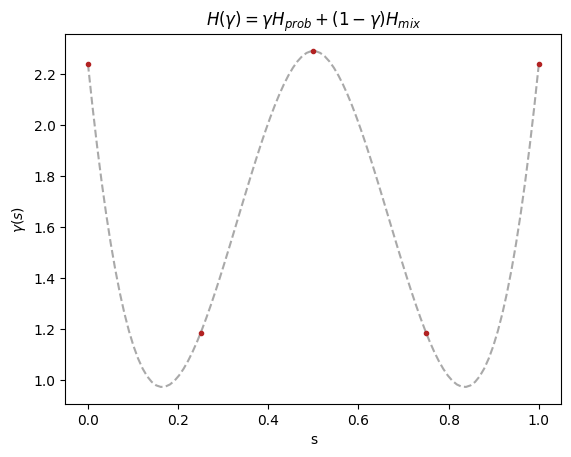

In [8]:
loss_opt = loss_ra(x1_opt, x2_opt, x3_opt)
print('Optimized spectral gap = ', -loss_opt.round(4))

schedule_opt = get_symmetric_schedule([x1_opt, x2_opt, x3_opt])
plot_schedule(schedule_opt, get_schedule_interpolator(schedule_opt, 'cubic')) 

In [9]:
ra_exp = {'n': n,
          'T': T,
          'interpolator_kind': interpolator_kind,
          't_max': t_max,
          'schedule_opt': schedule_opt.tolist(),
          'loss_opt': loss_opt,
          'first_optimizer': 'BO',
          'second_optimizer': 'None',
          'n_random_models': 1
          }

save_in_json(ra_exp, f'n{n}_{interpolator_kind}_BO.json')